# Jupyter Notebook for Validation of Results

## Overview

This notebook compares the results obtained from the two implementations, `shbundle` and `pyshbundle`, for a specific task.<br>We will focus on evaluating the following:
- Root Mean Squared Error (RMSE)
- Normalized Root Mean Squared Error (NRMSE)
- the difference in time series for a given basin.

## Evaluation Metrics

### 1. Root Mean Squared Error (RMSE)

The RMSE is a measure of the average magnitude of the errors between predicted and observed values.<br> It is calculated as follows:

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i - \bar{y}}\Big)^2}}$$

where:
- $n$ is the number of observations
- ${y_i}$ is the $i_{th}$ observation
- $\bar{y}$ is the mean of observations

### 2. Normalized Root Mean Squared Error (NRMSE)

NRMSE is a normalized version of RMSE, which provides a relative measure of the error compared to the range of the observed values. It is calculated as:

$$ NRMSE = \frac{RMSE}{\max(y) - \min(y)}$$

### 3. Difference in Time Series

We will also visually inspect the difference in time series obtained from both methods to identify any patterns or discrepancies.


## Data Preparation

Before proceeding with the analysis, ensure that the data from both `shbundle` and `pyshbundle` are loaded into the notebook.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# import proplot
import os
import pyshbundle

/tmp/ipykernel_3423/1291284098.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Initializing PySHbundle v0.0.1


In [2]:
''' Load tws processed data from shbundle as .mat file & from pyshbundle as xarray dataset '''
import scipy.io
# Load the .mat file
data = scipy.io.loadmat('../pyshbundle/validation_data/tws_m.mat')
# Access the variables in the .mat file
var1 = data['tws_m']

temp=xr.open_dataset('../pyshbundle/validation_data/tws_py.nc', engine="netcdf4")
var2=temp.tws.values

### Area Weighting
 grid size is $1^\circ$

In [3]:
# Calculation of area of each corresponding to  the latitudes and longitudes
deg = 1;
x = np.linspace(0, 359+(1-deg), int(360/deg), dtype='double');
y = np.linspace(0, 179+(1-deg), int(180/deg), dtype='double');
x1 = np.linspace(1*deg, 360, int(360/deg), dtype='double');
y1 = np.linspace(1*deg, 180, int(180/deg), dtype='double');
lambd,theta = np.meshgrid(x,y)  
lambd1,theta1 = np.meshgrid(x1,y1)  
a = np.sin(np.deg2rad(90-theta))-np.sin(np.deg2rad(90-theta1))
b = (lambd1 - lambd)*np.pi/180


# Area of each grid (360*720)
area = (6378.137**2)*pow(10,6)*(np.multiply(a,b))        # units m^2

#Multiply with the TWS datasets
# var1_=np.zeros(var1.shape)
# var2_=np.zeros(var2.shape)
# for i in range(0,var1.shape[0],1):
#     var1_[i,:,:] = np.multiply(var1[i,:,:],area)
#     var2_[i,:,:] = np.multiply(var2[i,:,:],area)

In [4]:
''' Write data to netcdf files to clip using geopandas '''
gs=1;
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
tws_py_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var2)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)

tws_m_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var1)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
tws_py_jpl, tws_m_jpl

(<xarray.Dataset>
 Dimensions:  (time: 252, lat: 180, lon: 360)
 Coordinates:
   * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
   * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
   * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
 Data variables:
     tws      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...,
 <xarray.Dataset>
 Dimensions:  (time: 252, lat: 180, lon: 360)
 Coordinates:
   * time     (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
   * lat      (lat) int64 89 88 87 86 85 84 83 82 ... -84 -85 -86 -87 -88 -89 -90
   * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
 Data variables:
     tws      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
 Attributes:
     description:  TWS Anomaly corresponding to long term (2004-2010) mea

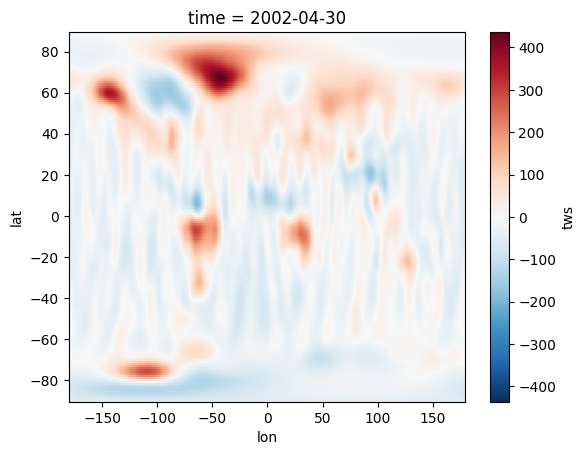

In [5]:
tws_py_jpl.tws.isel(time=3).plot()

### Gridwise RMSE calculation`

#### Creating a mask to remove the months of data which is missing (NaN)

In [6]:
nan_mask = np.all(np.isnan(tws_py_jpl.tws.values), axis=(1, 2))
nan_mask

array([ True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False,

In [7]:
var1[~nan_mask].shape   # we see that the size of data has reduced to 196 months

(196, 180, 360)

In [8]:
diff = var1[~nan_mask] - var2[~nan_mask]
squared_diff=diff**2
mean_squared_diff=np.mean(squared_diff, axis=0)
rmse=np.sqrt(mean_squared_diff)
nrmse=rmse/np.std(var1[~nan_mask], axis=0)
std_=np.std(var1[~nan_mask], axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '../pyshbundle/pic/02_error_rmse.png'

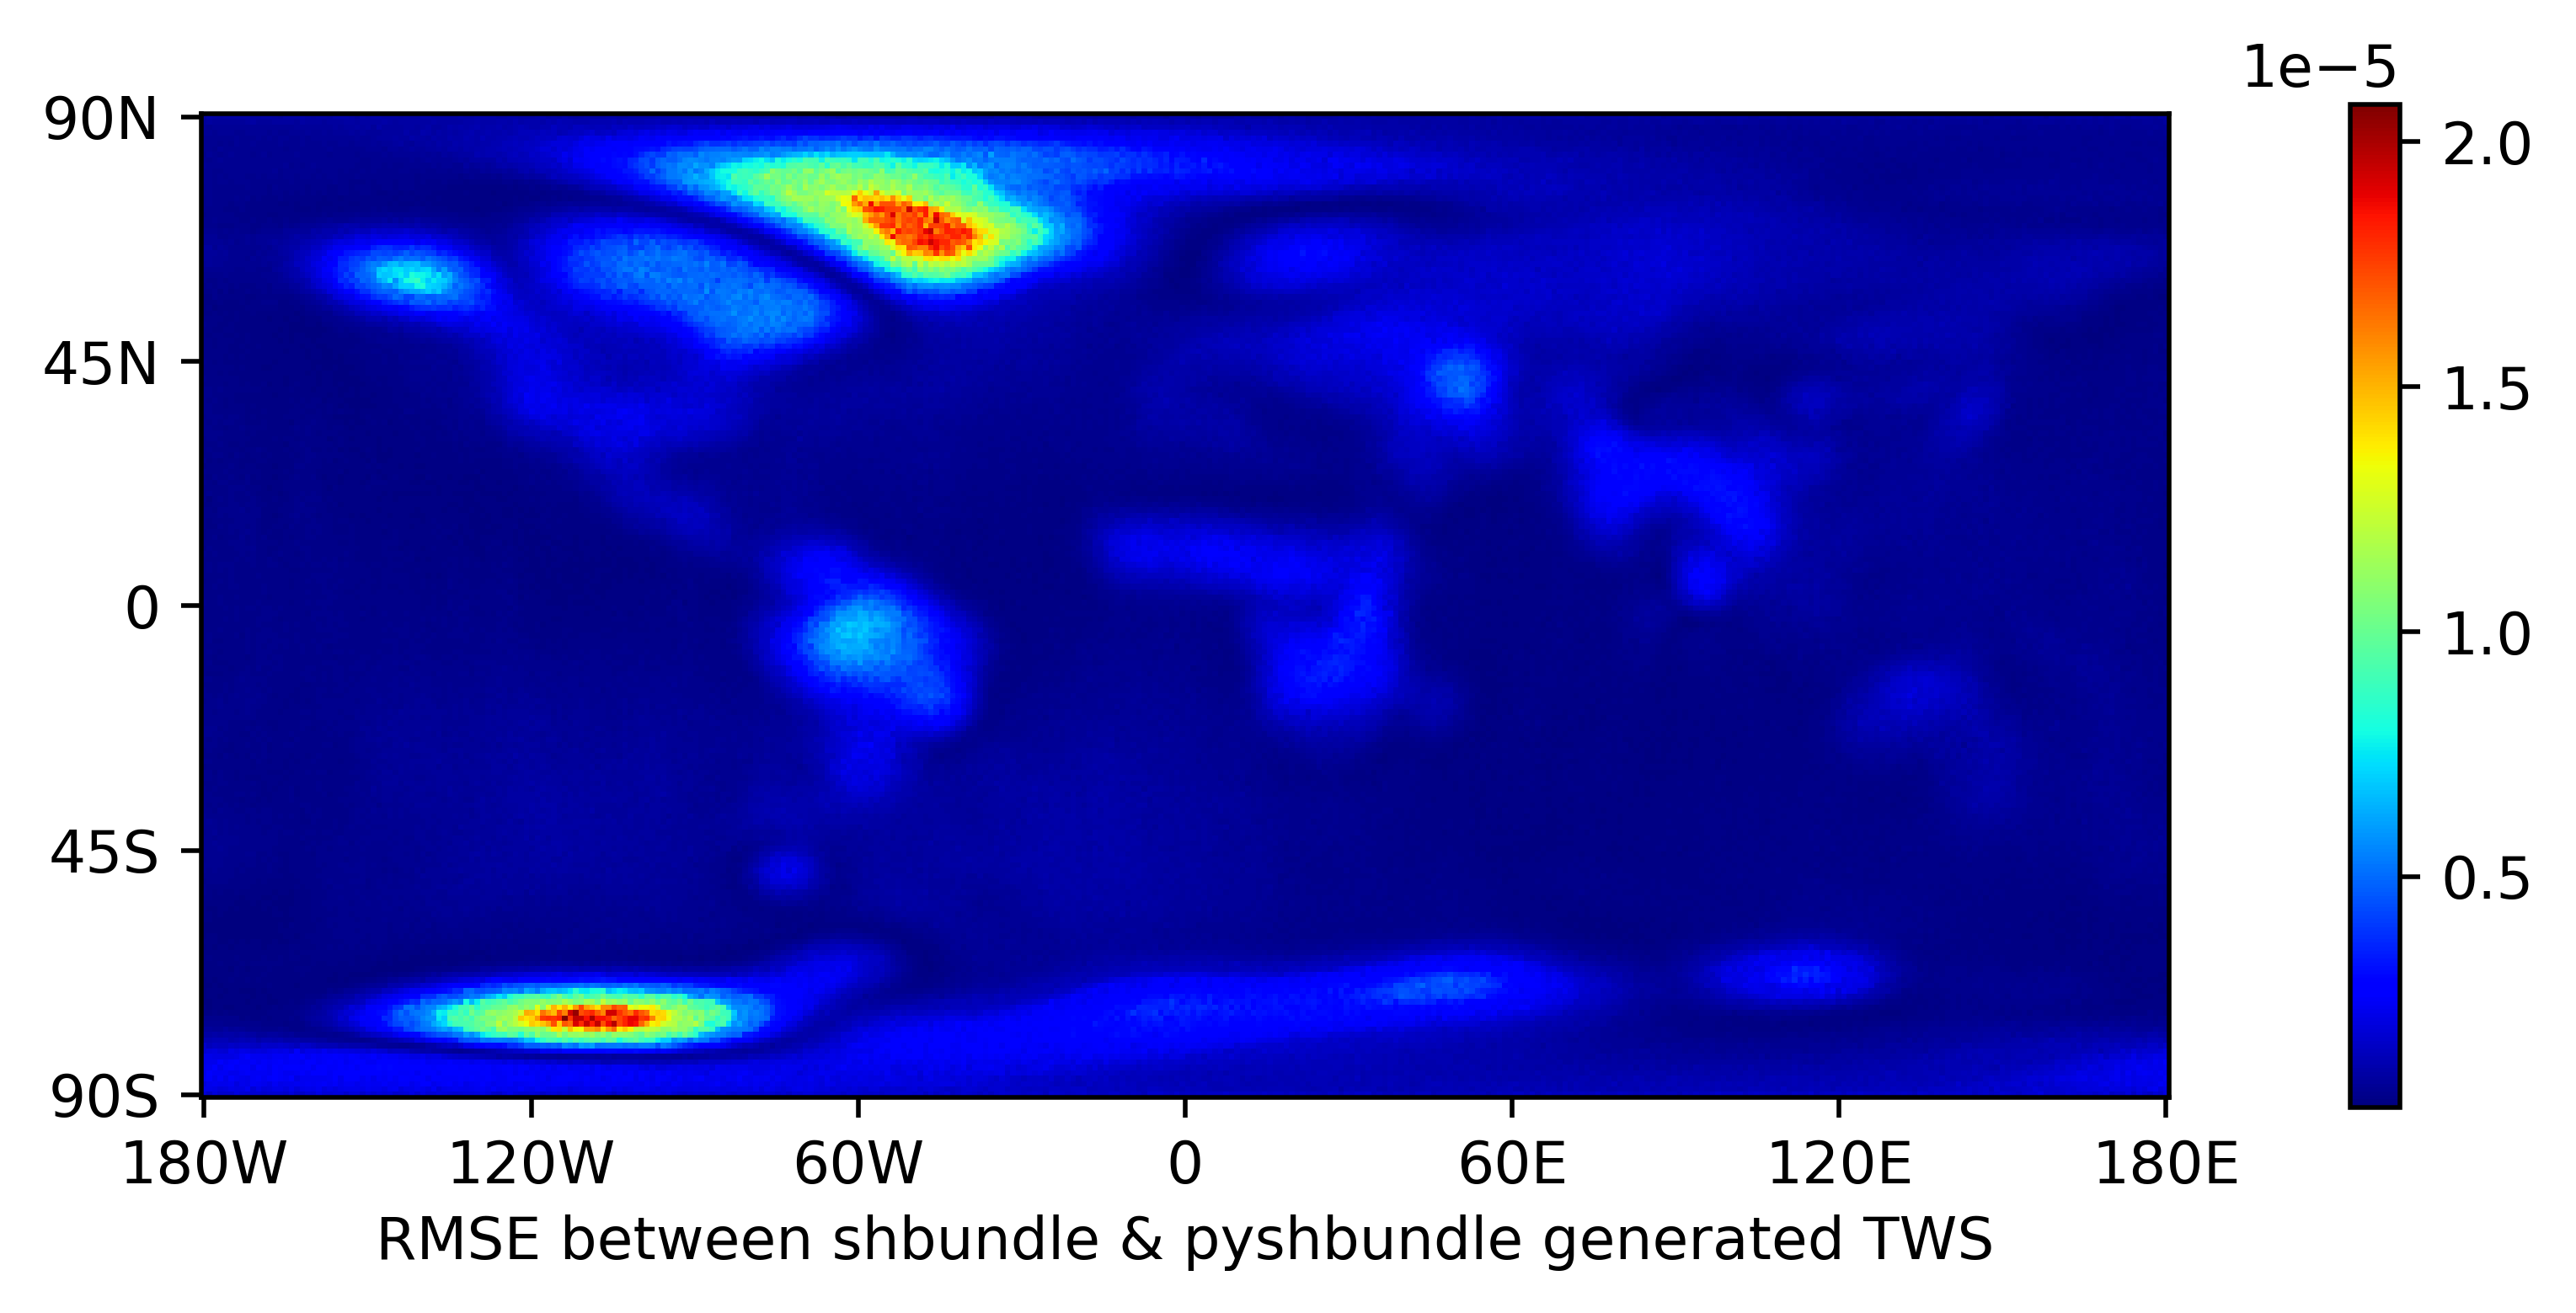

In [9]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=500, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(rmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('RMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


plt.savefig('../pyshbundle/pic/02_error_rmse.png')
plt.show()

In [ ]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=500, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(nrmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('NRMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


plt.savefig('../pyshbundle/pic/02_error_nrmse.png')
plt.show()

### `Basin avg RMSE`

In [10]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

<Axes: >

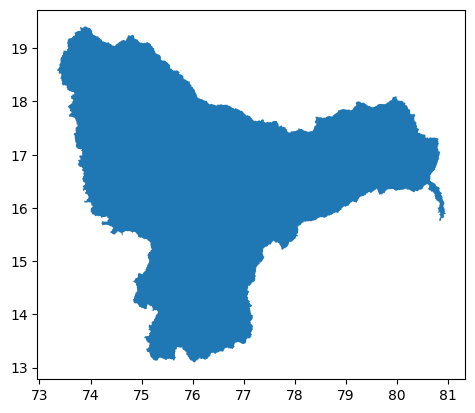

In [11]:
# import shapefile
path='../pyshbundle/data/basin_shapefiles/krishna_basin.shp'
shp = gpd.read_file(path)
shp.plot()

In [12]:
shp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   HYBAS_ID   1 non-null      int64   
 1   NEXT_DOWN  1 non-null      int64   
 2   NEXT_SINK  1 non-null      int64   
 3   MAIN_BAS   1 non-null      int64   
 4   DIST_SINK  1 non-null      float64 
 5   DIST_MAIN  1 non-null      float64 
 6   SUB_AREA   1 non-null      float64 
 7   UP_AREA    1 non-null      float64 
 8   PFAF_ID    1 non-null      int64   
 9   ENDO       1 non-null      int64   
 10  COAST      1 non-null      int64   
 11  ORDER      1 non-null      int64   
 12  SORT       1 non-null      int64   
 13  geometry   1 non-null      geometry
dtypes: float64(4), geometry(1), int64(9)
memory usage: 240.0 bytes


In [13]:
# temp=shp['RIVER_BASI']
# basin_name=global_name='AMAZON (also AMAZONAS)'   #'AMAZON (also AMAZONAS)'  #'GANGES'

     HYBAS_ID  NEXT_DOWN   NEXT_SINK    MAIN_BAS  DIST_SINK  DIST_MAIN  \
0  4040027940          0  4040027940  4040027940        0.0        0.0   

   SUB_AREA   UP_AREA  PFAF_ID  ENDO  COAST  ORDER  SORT  \
0  258784.2  258784.2     4536     0      0      1    95   

                                            geometry  
0  POLYGON ((76.64167 13.36667, 76.64077 13.36316...  
Basin area is : 0    2.183258e+11
dtype: float64 m²


/tmp/ipykernel_3423/3645888501.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basin_area= shp_hel['geometry'].area*1e6*1e3*1e1 # basin area already in m^2


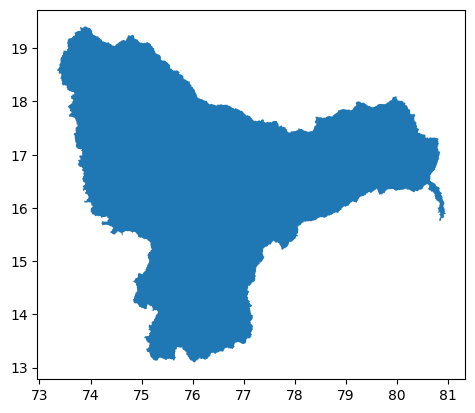

In [30]:
# [shp['RIVER_BASI']==global_name]
shp_hel=shp
print(shp_hel.head())
shp_hel.plot()
basin_area= shp_hel['geometry'].area*1e6*1e3*1e1 # basin area already in m^2
print('Basin area is :', basin_area, 'm\u00b2');

In [31]:
tws_py_jpl=tws_py_jpl*area;
tws_m_jpl=tws_m_jpl*area;

In [34]:
# clip data using shapefile
''' add projection system to nc '''
basin_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_py_jpl_ = basin_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
basin_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_m_jpl_ = basin_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws_py_jpl = basin_tws_py_jpl_.rio.clip(shp_hel.geometry.apply(mapping), shp_hel.crs,drop=False)
basin_tws_m_jpl = basin_tws_m_jpl_.rio.clip(shp_hel.geometry.apply(mapping), shp_hel.crs,drop=False)

basin_avg_tws_py_jpl=basin_tws_py_jpl.tws.sum(dim=('lon','lat'), skipna=True)/basin_area
basin_avg_tws_m_jpl=basin_tws_m_jpl.tws.sum(dim=('lon','lat'), skipna=True)/basin_area

ValueError: Length of values (252) does not match length of index (1)

In [35]:
# diff of shbundle and pyshbundle
diff_basin_avg_tws=basin_avg_tws_m_jpl.data-basin_avg_tws_py_jpl.data

NameError: name 'basin_avg_tws_m_jpl' is not defined

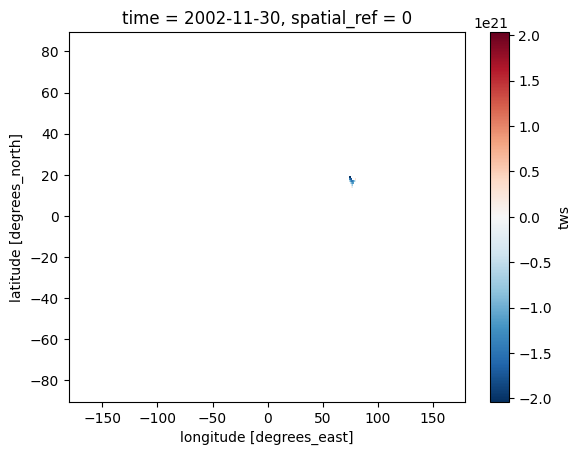

In [36]:
basin_tws_py_jpl.tws.isel(time=10,).plot()

In [18]:
diff_basin_avg_tws

NameError: name 'diff_basin_avg_tws' is not defined

In [19]:
basin_avg_tws_py_jpl = basin_avg_tws_py_jpl.where(~nan_mask, np.nan)
basin_avg_tws_m_jpl = basin_avg_tws_m_jpl.where(~nan_mask, np.nan)


NameError: name 'basin_avg_tws_py_jpl' is not defined

In [20]:
diff_basin_avg_tws[nan_mask]=np.nan
diff_basin_avg_tws

NameError: name 'diff_basin_avg_tws' is not defined

In [21]:
# Create lists for each data
data_list = [basin_avg_tws_m_jpl, basin_avg_tws_py_jpl,diff_basin_avg_tws]  
label_list = ['shbundle implementation', 'pyshbundle implementation','Difference of basin averaged TWSA: shbundle - pyshbundle']
# legend_list = ['Monthly TWSA', 'Monthly TWSA', 'Difference in monthky']
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)

# Iterate over each subplot
for i, ax in enumerate(axes):
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, data_list[i], label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]}')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.85, 0.9,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
fig.suptitle(f'TWSA basin averaged time series for {basin_name}')
plt.show()
fig.savefig(f'../pyshbundle/pic/03_basin_avg_tws_{basin_name}.png')

NameError: name 'basin_avg_tws_m_jpl' is not defined

#### Global area weighted water budget closure

In [22]:
# Area of grids
global_grid_area = np.sum(area)
print(f'global surface area:', {global_grid_area})

global surface area: {511207893395810.94}


In [23]:
# clip data using shapefile
''' add projection system to nc '''
global_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
global_tws_py_jpl_ = global_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
global_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
global_tws_m_jpl_ = global_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
global_avg_tws_py_jpl=global_tws_py_jpl_.tws.sum(dim=('lon','lat'), skipna=True)/global_grid_area
global_avg_tws_m_jpl=global_tws_m_jpl_.tws.sum(dim=('lon','lat'), skipna=True)/global_grid_area

In [24]:
global_avg_tws_py_jpl=global_avg_tws_py_jpl.where(~nan_mask, np.nan)
global_avg_tws_m_jpl=global_avg_tws_m_jpl.where(~nan_mask, np.nan)

In [25]:
diff_global=global_avg_tws_m_jpl-global_avg_tws_py_jpl
diff_global=diff_global.where(~nan_mask, np.nan)
diff_global

<xarray.DataArray 'tws' (time: 252)>
array([            nan,             nan,             nan,  5.87495288e-09,
       -4.26219931e-09,             nan,             nan, -1.39690915e-08,
       -7.80650405e-09, -6.42466711e-09, -8.19053528e-09,  6.63722156e-09,
        9.31248977e-09, -5.73922119e-09,  1.89796942e-09,  8.24559288e-09,
        3.79565113e-09,             nan,  1.93736307e-09, -1.83971204e-09,
        3.81903092e-09, -2.62595572e-09, -2.38501625e-09, -1.87194534e-10,
       -1.11290191e-09,  9.30277526e-10,  2.59435171e-09,  2.16738372e-10,
        2.78564527e-09, -7.79717097e-09,             nan,             nan,
                   nan,             nan,  1.23424930e-09, -6.35301761e-09,
        1.16984379e-10,  1.88050509e-09, -4.28004151e-09, -2.50724203e-09,
        9.53246653e-09,  6.83307619e-09,  2.47473032e-09,  8.28585819e-10,
       -1.35003030e-09, -1.28248985e-09, -5.63240374e-09,  2.24804612e-09,
       -3.87200305e-10, -6.36321805e-09, -6.67632138e-09,  1.87592994e-09,
        2.03897609e-09,  2.05827316e-09,  1.07553829e-11, -1.64323288e-09,
        2.35863025e-09,  3.71171035e-10, -2.67427042e-09, -6.57372926e-09,
        5.83936549e-10, -2.58795057e-09, -1.10072776e-09,  3.78735460e-09,
        1.29334583e-09, -3.38108048e-09,  7.70711592e-11,  3.39186313e-11,
       -9.98676250e-09, -6.64016670e-09, -7.93387669e-12, -1.23655189e-09,
       -1.55859982e-09, -2.62608584e-09,  5.01678100e-09, -3.52715367e-09,
       -6.91498006e-09, -1.66997045e-09,  1.49251482e-10,  4.41058185e-09,
...
       -2.25715351e-09,  3.90585842e-09, -7.19806656e-10,  9.95091976e-09,
                   nan,             nan,  1.84929928e-09,  4.66815872e-09,
        1.02632301e-08,             nan, -6.80607209e-09,  1.77905282e-08,
        8.67088018e-09,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  1.34698503e-08,  1.69769949e-10,             nan,
                   nan,  1.24826696e-08, -1.13186658e-08,  6.77686423e-09,
       -2.11027423e-10,             nan,  8.87058491e-09,  6.98574838e-10,
       -1.24433551e-08, -6.44041247e-09,  1.04641976e-09,  6.78977265e-09,
       -1.17973808e-09, -1.28959576e-09,  3.04482389e-10,  4.69978645e-09,
        4.11641950e-09,  1.30738904e-08, -1.37414674e-08,  1.06418618e-08,
        9.08540381e-09,  4.90126906e-09,  6.11483215e-09, -6.40431628e-09,
        1.84916244e-08, -6.10343720e-09,  6.43380792e-09,  1.89344823e-08,
        4.24699269e-09,  3.45377812e-09,  3.00121080e-10, -7.83998232e-10,
        4.93618371e-09, -2.34314574e-09,  4.80703740e-09, -9.03252581e-09,
       -2.54969338e-09,  6.18850278e-09,  1.40659115e-08, -4.17270357e-09,
        6.13673100e-09,  4.88609934e-09,  1.56515550e-08,  3.92764909e-09,
       -5.24295334e-09,  1.21711383e-08,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
    spatial_ref  int64 0

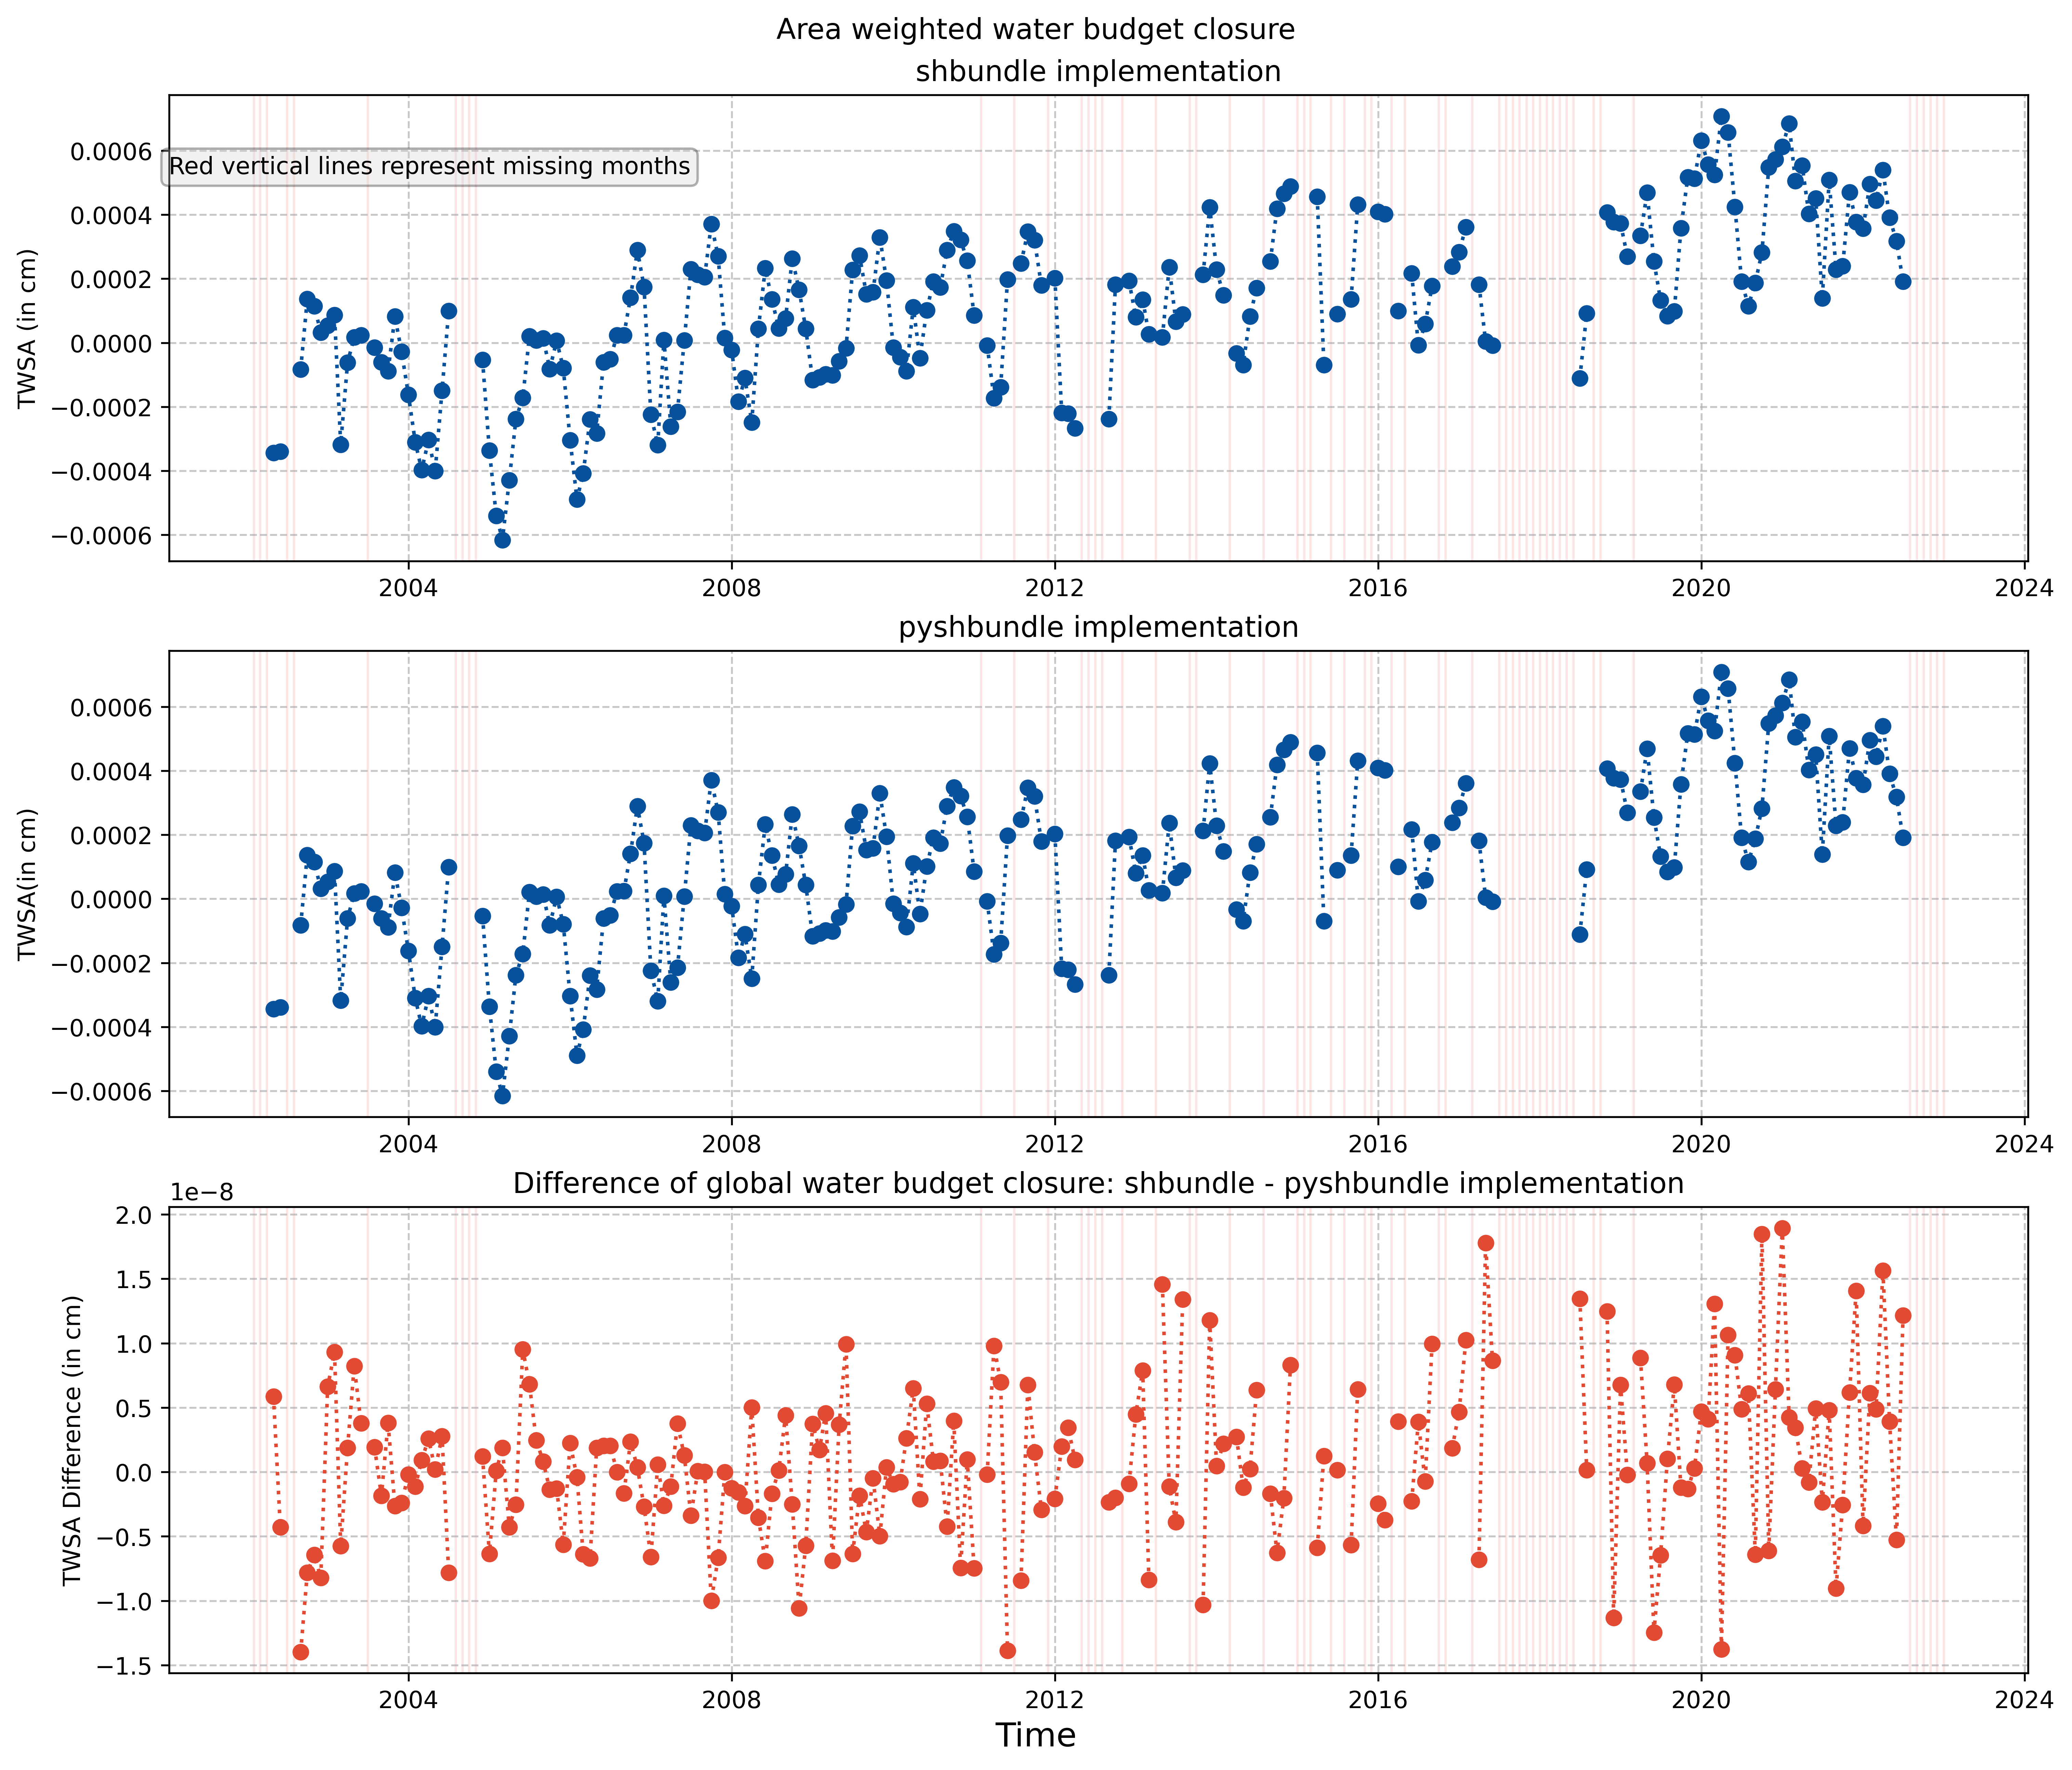

In [26]:
# Create lists for each data
data_list = [global_avg_tws_m_jpl, global_avg_tws_py_jpl,diff_global]  
label_list = ['shbundle', 'pyshbundle','Difference of global water budget closure: shbundle - pyshbundle']  
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'TWSA Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)

# Iterate over each subplot
for i, ax in enumerate(axes):
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, data_list[i], label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]} implementation')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.14, 0.845,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
fig.suptitle(f'Area weighted water budget closure')
plt.show()
# fig.savefig(f'./global_wb_closure.png')